# Visualizations of the examples from train set nearest to a given vector from the last capsule layer

In [1]:
%matplotlib notebook

from keras import backend as K
from keras.datasets import mnist
from keras.models import load_model

from keras.layers import Input, Conv2D, Activation, Dense, Dropout
from keras.layers import BatchNormalization, MaxPooling2D, Flatten
from convcaps.capslayers import ConvertToCaps, Conv2DCaps, FlattenCaps
from convcaps.capslayers import DenseCaps, CapsToScalars

from keras.utils import to_categorical
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive
import ipywidgets as widgets

from naive import do_routing

Using TensorFlow backend.


### Load dataset

In [2]:
img_rows, img_cols = 28, 28
num_classes = 10

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# since we use only tf the channel is last
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

batch_size = 32

### Load pretrained model

In [3]:
model = load_model('cc_weights.0.08-0.0003-0.0003-0.9924-0.0005-0.9875.hdf5',
                   custom_objects={'ConvertToCaps': ConvertToCaps,
                                   'Conv2DCaps': Conv2DCaps,
                                   'FlattenCaps': FlattenCaps,
                                   'DenseCaps': DenseCaps,
                                   'CapsToScalars': CapsToScalars},
                   compile=False)

### Take apart the model and get weights of next to last layer

In [4]:
inp = model.input
layers = [layer for layer in model.layers]
outputs = [layer.output for layer in layers]
functors = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]

x = x_test[0:batch_size]
res = [functors[i]([x, False])[0] for i in range(len(functors))]

w = layers[7].get_weights()[0]

### Calculate pv - the output vectors 

In [5]:
sz = x_train.shape[0] // batch_size * batch_size
p = np.zeros((sz, 10, 8))

for i in range(0, sz, batch_size):
    x = x_train[i:i+batch_size]
    y = x_train[i:i+batch_size]
    xi = functors[6]([x, False])[0]
    p[i:i+batch_size, :, :] = do_routing(xi, w, 3)

pl = np.sum(np.square(p), axis=-1)
pn = np.argmax(pl, axis=-1)
pv = np.array([p[n, pn[n]] for n in range(pn.shape[0])])

### Show digits that have vectors nearest to a given vector

<IPython.core.display.Javascript object>


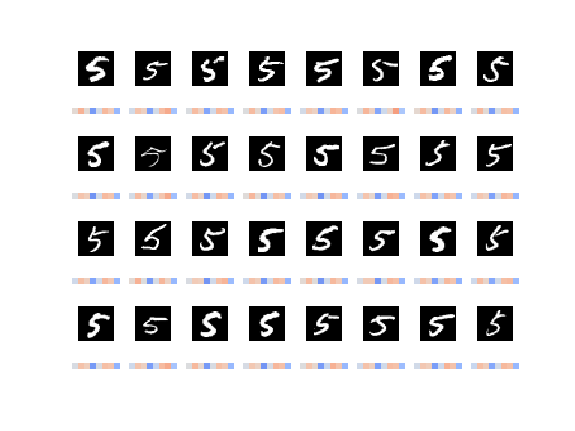

A Jupyter Widget

In [15]:
f = plt.figure()
pics = []
vecs = []

for r in range(4):
    for c in range(8):
        pics.append(f.add_subplot(8, 8, r*2*8 + c + 1))
        vecs.append(f.add_subplot(8, 8, r*2*8 + 8 + c + 1))

def clear_pics():
    for i in range(len(pics)):
        pics[i].cla()
        pics[i].axis('off')
        vecs[i].cla()
        vecs[i].axis('off')
        
def update(**kwargs):
    vvals = np.array(list(kwargs.values()))
    clear_pics()

    # idx = np.logical_and((pv[:, 1] > 0.9), (pv[:, 1] < 0.91))
    ds = np.sum(np.sqrt(np.square((pv - vvals))), axis=-1)
    idx = np.argsort(ds)[:32]
    #print(ds[idx])

    lx = x_train[idx]
    lpv = pv[idx]

    for i in range(32):
        pics[i].imshow(lx[i, :, :, 0], cmap=cm.gray)
        vecs[i].imshow(lpv[i].reshape((1, -1)), cmap=cm.coolwarm,
                       vmin=-1, vmax=1)

    f.canvas.draw()
    
tmp = pv[1313]  # choose a vector of en example from train set
sls = {'n%d' % (i,): widgets.FloatSlider(min=-1.0, max=1.0, step=0.05, value=tmp[i])
       for i in range(8)}

plt.show()

interact(update, **sls);